In [1]:
#py_geospatial env
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import glob
import process_ISIMIP as pISIMIP
import xesmf as xe

#### Merge ISIMIP datasets for each scenario
Since ISIMIP data is downloaded in time chunks, these chunks need to be merged for each variable and scenario to make further analysis more convenient.  
For each GCM, this code block merges all the chunks for each variable and scenario to one dataset.  

This is only done once.

In [2]:
src_isimip = r"D:\VUB\_data\_isimip_3b"
models = list(map(str.upper, ['gfdl-esm4', 'ipsl-cm6a-lr', 'mpi-esm1-2-hr', 'mri-esm2-0', 'ukesm1-0-ll']))
scenarios = ['historical', 'ssp126', 'ssp370', 'ssp585']
variables = ['pr', 'tasmin', 'tasmax']

# Merge ISIMIP datasets for each scenario
pISIMIP.merge_ISIMIP_datasets(src_isimip, models, scenarios, variables, verbose=False)

{('GFDL-ESM4', 'historical', 'pr'): {'files_found': 6, 'merged': False},
 ('GFDL-ESM4', 'historical', 'tasmin'): {'files_found': 6, 'merged': False},
 ('GFDL-ESM4', 'historical', 'tasmax'): {'files_found': 6, 'merged': False},
 ('GFDL-ESM4', 'ssp126', 'pr'): {'files_found': 9, 'merged': False},
 ('GFDL-ESM4', 'ssp126', 'tasmin'): {'files_found': 9, 'merged': False},
 ('GFDL-ESM4', 'ssp126', 'tasmax'): {'files_found': 9, 'merged': False},
 ('GFDL-ESM4', 'ssp370', 'pr'): {'files_found': 9, 'merged': False},
 ('GFDL-ESM4', 'ssp370', 'tasmin'): {'files_found': 9, 'merged': False},
 ('GFDL-ESM4', 'ssp370', 'tasmax'): {'files_found': 9, 'merged': False},
 ('GFDL-ESM4', 'ssp585', 'pr'): {'files_found': 9, 'merged': False},
 ('GFDL-ESM4', 'ssp585', 'tasmin'): {'files_found': 9, 'merged': False},
 ('GFDL-ESM4', 'ssp585', 'tasmax'): {'files_found': 9, 'merged': False},
 ('IPSL-CM6A-LR', 'historical', 'pr'): {'files_found': 6, 'merged': False},
 ('IPSL-CM6A-LR', 'historical', 'tasmin'): {'files_f

#### Import obs. data and compare with GCM data

In [3]:
src = r'D:/VUB/_data/mHM_EOBS'

#Data already clipped to domain boundaries
tmax_EOBS = xr.open_dataset(f'{src}/tmax.nc')
tmin_EOBS = xr.open_dataset(f'{src}/tmin.nc')
pr_EOBS = xr.open_dataset(f'{src}/pre.nc')

isimip_data = {}

#Open the datasets for each model and scenario
for model in models:
    for scenario in scenarios:
        for variable in variables:
            file_path = f"{src_isimip}/{model}/{scenario}/{model}_{variable}_merged.nc"
            if glob.glob(file_path):
                isimip_data[(model, scenario, variable)] = xr.open_dataset(file_path)


In [4]:
#select historical tasmin for all models
tasmin_hist = {(model, 'historical'): isimip_data[(model, 'historical', 'tasmin')] for model in models if (model, 'historical', 'tasmin') in isimip_data}
tasmax_hist = {(model, 'historical'): isimip_data[(model, 'historical', 'tasmax')] for model in models if (model, 'historical', 'tasmax') in isimip_data}
pr_hist = {(model, 'historical'): isimip_data[(model, 'historical', 'pr')] for model in models if (model, 'historical', 'pr') in isimip_data}
pr_future = {(model, 'ssp370'): isimip_data[(model, 'ssp370', 'pr')] for model in models if (model, 'ssp370', 'pr') in isimip_data}
tmax_future = {(model, 'ssp585'): isimip_data[(model, 'ssp585', 'tasmax')] for model in models if (model, 'ssp585', 'tasmax') in isimip_data}

#compare with EOBS
tasmin_dict={}
tasmax_dict={}
pr_dict={}
tmax_future_dict={}

for model in models:
    if (model, 'historical', 'tasmin') in isimip_data:
        tasmin_df = (tasmin_hist[(model, 'historical')]['tasmin']-273.15).sel(lat=45, lon=5,
                                                                      method='nearest').to_dataframe().drop(columns=['lat', 'lon']).resample('D').mean()
        tasmin_df.columns = [model]

        tasmax_df = (tasmax_hist[(model, 'historical')]['tasmax']-273.15).sel(lat=45, lon=5,
                                                                      method='nearest').to_dataframe().drop(columns=['lat', 'lon']).resample('D').mean()
        tasmax_df.columns = [model]

        pr_df = (pr_hist[(model, 'historical')]['pr']*86400).sel(lat=45, lon=5,
                                                                 method='nearest').to_dataframe().drop(columns=['lat', 'lon']).resample('D').sum()
        pr_df.columns = [model]

        tmax_future_df = (tmax_future[(model, 'ssp585')]['tasmax']-273.15).sel(lat=45, lon=5,
                                                                      method='nearest').to_dataframe().drop(columns=['lat', 'lon']).resample('D').mean()
        tmax_future_df.columns = [f"{model}_ssp370"]
        
        tasmin_dict[model] = tasmin_df
        tasmax_dict[model] = tasmax_df
        pr_dict[model] = pr_df
        tmax_future_dict[model] = tmax_future_df


#convert to pandas DataFrame
tasmin_df_ = pd.concat(tasmin_dict.values(), axis=1)
tasmax_df_ = pd.concat(tasmax_dict.values(), axis=1)
pr_df_ = pd.concat(pr_dict.values(), axis=1)
tmax_future_df_ = pd.concat(tmax_future_dict.values(), axis=1)


#select EOBS data
tmin_df = tmin_EOBS['tmin'].sel(lat=45, lon=5, method='nearest').to_dataframe().drop(columns=['lat', 'lon']).resample('D').mean()
pr_df = pr_EOBS['pre'].sel(lat=45, lon=5, method='nearest').to_dataframe().drop(columns=['lat', 'lon']).resample('D').sum()
tmax_df = tmax_EOBS['tmax'].sel(lat=45, lon=5, method='nearest').to_dataframe().drop(columns=['lat', 'lon']).resample('D').mean()


#### Comparison Plots

Text(0, 0.5, 'Temperature ($^0$C)')

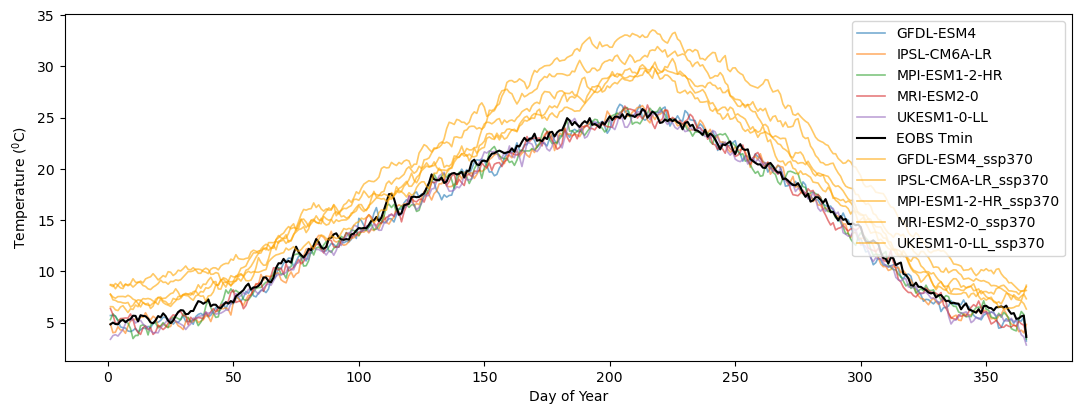

In [5]:

fig, ax = plt.subplots(figsize=(13, 4.5))


# Plotting the data
plt.plot(tasmax_df_.groupby(tasmin_df_.index.dayofyear).mean(), label=tasmin_df_.columns, alpha=0.6, lw=1.2)
plt.plot(tmax_df.groupby(tmin_df.index.dayofyear).mean(), color='k', label='EOBS Tmin')
plt.plot(tmax_future_df_.groupby(tmax_future_df_.index.dayofyear).mean(), label=tmax_future_df_.columns, alpha=0.6, lw=1.2, c='orange')
plt.legend(loc='upper right', ncol=1)
plt.xlabel('Day of Year')
plt.ylabel('Temperature ($^0$C)')

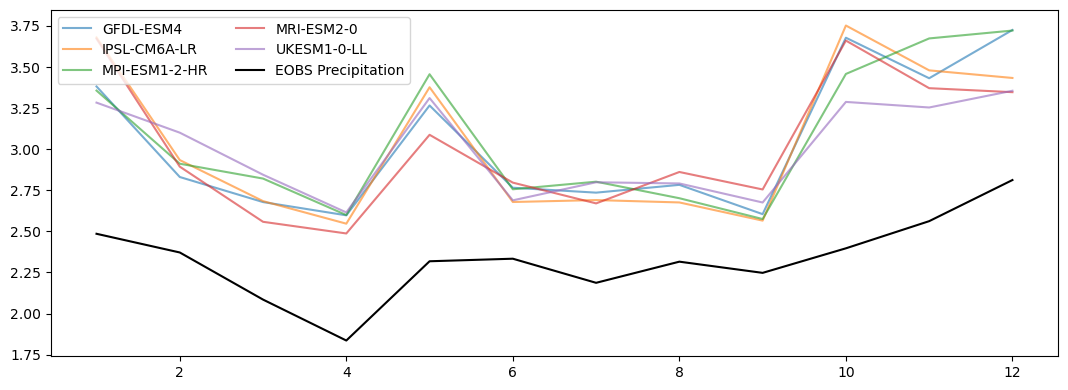

In [6]:
#Rainfall data

fig, ax = plt.subplots(figsize=(13, 4.5))

plt.plot(pr_df_.groupby(pr_df_.index.month).mean(), label=pr_df_.columns, alpha=0.6)
plt.plot(pr_df.groupby(pr_df.index.month).mean(), color='k', label='EOBS Precipitation')
plt.legend(loc='upper left', ncol=2)

  

#### Regridding and Downscaling

In [7]:
import xarray as xr
from xclim.sdba.adjustment import EmpiricalQuantileMapping, QuantileDeltaMapping

# 1) Load your observed reference (E-OBS) and your historical model run
obs = pr_EOBS['pre'].where(pr_EOBS['pre'].var(dim='time')> 0.001)  # Filter out non-positive values
sim_hist = pr_hist[('GFDL-ESM4', 'historical')]['pr'] * 86400  # Convert from kg m-2 s-1 to mm/day
sim_future = pr_future[('GFDL-ESM4', 'ssp370')]['pr'] * 86400  # Convert from kg m-2 s-1 to mm/day
sim_hist = sim_hist.assign_attrs(units="mm d-1", standard_name="precipitation_flux")

obs = obs.sel(time=slice('1971-01-01','2014-12-31'))  # Select the same time period as the historical simulation


#regrid with xesmf
regridder = xe.Regridder(sim_hist, obs, method='bilinear')

# Apply the regridder to the historical simulation
sim_hist_regrid = regridder(sim_hist)
# Apply the regridder to the future simulation
sim_future_regrid = regridder(sim_future)
sim_hist = sim_hist_regrid.assign_attrs(units="mm d-1", standard_name="precipitation_flux")
sim_future = sim_future_regrid.assign_attrs(units="mm d-1", standard_name="precipitation_flux")

#Make a mask where obs is not null
valid_mask = obs.notnull().any(dim="time")

#simhist where variance is not zero
sim_hist = sim_hist.where(sim_hist.var(dim='time') > 0.0001)
sim_hist = sim_hist.where(valid_mask)

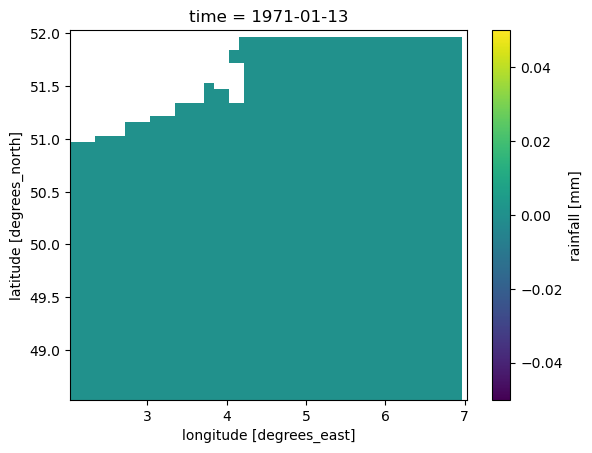

In [8]:
obs[12].plot(robust=True, label='EOBS')


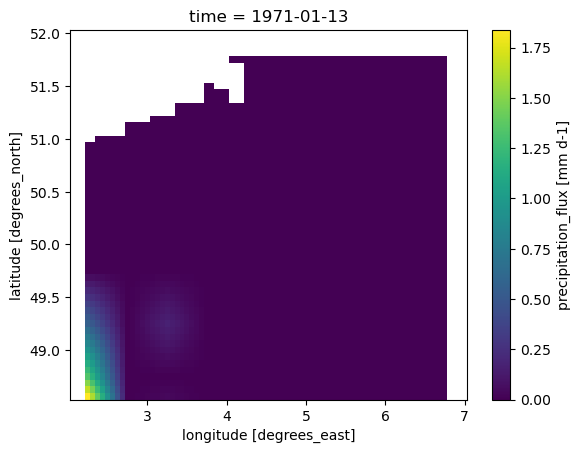

In [9]:
sim_hist[12].plot()

In [10]:
import numpy as np
import xarray as xr

# 1) helper: jitter *only* the zeros
def jitter_zeros(arr: np.ndarray, jitter: float = 1e-3) -> np.ndarray:
    out = arr.astype(np.float64).copy()
    mask = (out == 0)
    noise = np.random.uniform(-jitter, jitter, size=out.shape)
    out[mask] += noise[mask]
    out[out < 0] = 0.0
    return out

# 2) helper: compute quantiles
def compute_eqm_mapping(obs_vals, hist_vals, n_q=51):
    mask = (~np.isnan(obs_vals)) & (~np.isnan(hist_vals))
    probs = np.linspace(0, 1, n_q)
    q_hist = np.quantile(hist_vals[mask], probs)
    q_obs  = np.quantile(obs_vals [mask], probs)
    return probs, q_hist, q_obs

# 3) helper: apply EQM
def apply_eqm(sim_vals, q_hist, q_obs, kind="*", extrap="constant"):
    if kind == "*":
        af = np.ones_like(q_hist)
        nz = q_hist > 0
        af[nz] = q_obs[nz] / q_hist[nz]
    else:
        af = q_obs - q_hist
    corr = np.interp(sim_vals, q_hist, af,
                     left=(af[0]   if extrap=="constant" else np.nan),
                     right=(af[-1] if extrap=="constant" else np.nan))
    if kind == "*":
        out = sim_vals * corr
        out[sim_vals == 0] = 0.0
    else:
        out = sim_vals + corr
        out = np.clip(out, 0, None)
    return out


#### Application to timeseries

In [11]:
maxlat, minlat, minlon, maxlon = 51.5, 48.5, 4.5, 7.5


obs_df = obs.sel(lat=slice(maxlat, minlat), lon=slice(minlon, maxlon)).mean(dim=['lat', 'lon']).to_dataframe().resample('D').sum()
sim_hist_df = sim_hist.sel(lat=slice(maxlat, minlat), lon=slice(minlon, maxlon)).mean(dim=['lat', 'lon']).to_dataframe(name='pr_hist').resample('D').sum()
sim_future_df = sim_future.sel(lat=slice(maxlat, minlat), lon=slice(minlon, maxlon)).mean(dim=['lat', 'lon']).to_dataframe(name='pr_fut').resample('D').sum()

In [12]:
month = 3  # January

obs_jan = obs_df[obs_df.index.month == month].values.astype(np.float64)
sim_hist_jan = sim_hist_df[sim_hist_df.index.month == month].values.astype(np.float64)
sim_future_jan = sim_future_df[sim_future_df.index.month == month].values.astype(np.float64)

# jitter the model history (NOT the obs!)
#hist_jan_j = jitter_zeros(sim_hist_jan, jitter=1e-3)

hist_jan_j = jitter_zeros(sim_hist_jan, jitter=1e-3)
probs, q_hist, q_obs = compute_eqm_mapping(obs_jan, hist_jan_j, n_q=51)
hist_jan_bc = apply_eqm(sim_hist_jan, q_hist, q_obs, kind="*")


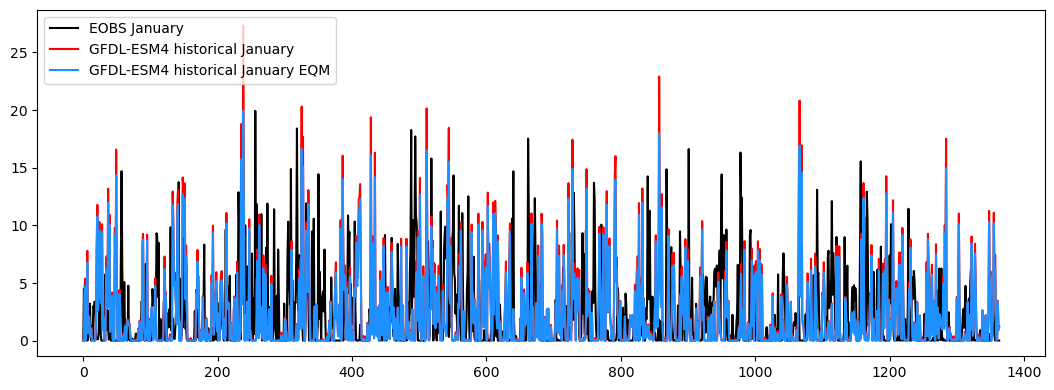

In [13]:
fig, ax = plt.subplots(figsize=(13, 4.5))

plt.plot(obs_jan, label='EOBS January', color='k')
plt.plot(sim_hist_jan, label='GFDL-ESM4 historical January', color='r')
plt.plot(hist_jan_bc, label='GFDL-ESM4 historical January EQM', color='dodgerblue')

plt.legend(loc='upper left', ncol=1)

Mean January EOBS: 2.16 mm
Mean January GFDL-ESM4 historical EQM: 2.15 mm
Mean January GFDL-ESM4 historical: 2.41 mm


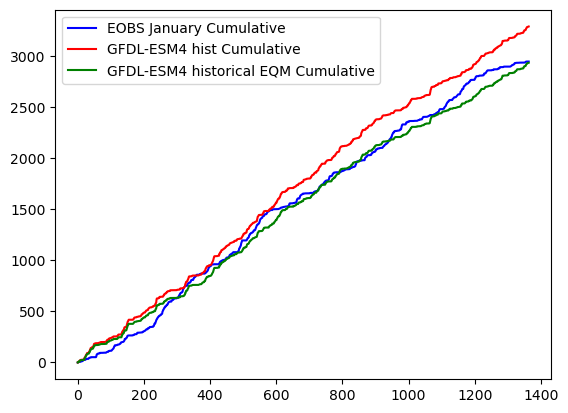

In [14]:
plt.plot(np.cumsum(obs_jan), c='b', label='EOBS January Cumulative')
plt.plot(np.cumsum(sim_hist_jan), c='r', label='GFDL-ESM4 hist Cumulative')
plt.plot(np.cumsum(hist_jan_bc), c='g', label='GFDL-ESM4 historical EQM Cumulative')
plt.legend(loc='upper left', ncol=1)

print(f"Mean January EOBS: {np.mean(obs_jan):.2f} mm")
print(f"Mean January GFDL-ESM4 historical EQM: {np.mean(hist_jan_bc):.2f} mm")
print(f"Mean January GFDL-ESM4 historical: {np.mean(sim_hist_jan):.2f} mm")

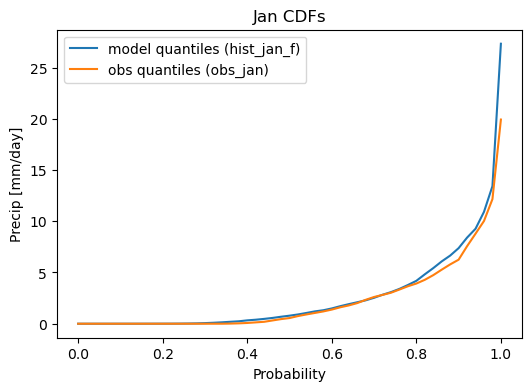

In [15]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
plt.plot(probs, q_hist, label="model quantiles (hist_jan_f)")
plt.plot(probs, q_obs,  label="obs quantiles (obs_jan)")
plt.xlabel("Probability")
plt.ylabel("Precip [mm/day]")
plt.legend()
plt.title("Jan CDFs")
plt.show()


In [16]:
obs, hist = xr.align(obs, sim_hist, join="inner")

In [ ]:
import numpy as np
import xarray as xr

# ── Helpers (zero‐only jitter + EQM) ────────────────────────────────

def jitter_zeros(arr, jitter=1e-3):
    out = arr.astype(np.float64).copy()
    zeros = out == 0
    noise = np.random.uniform(-jitter, jitter, size=out.shape)
    out[zeros] += noise[zeros]
    out[out < 0] = 0.0
    return out

def compute_eqm_mapping(o, h, n_q=51, min_samples=10):
    valid = (~np.isnan(o)) & (~np.isnan(h))
    if valid.sum() < min_samples:
        return None  # signal “skip”
    probs = np.linspace(0, 1, n_q)
    h_j = jitter_zeros(h)
    qh = np.quantile(h_j[valid], probs)
    qo = np.quantile(o [valid], probs)
    return probs, qh, qo

def apply_eqm_vec(x, qh, qo):
    af = np.ones_like(qh)
    nz = qh > 0
    af[nz] = qo[nz] / qh[nz]
    corr = np.interp(x, qh, af, left=af[0], right=af[-1])
    y = x * corr
    y[x == 0] = 0.0
    return y

# ── Main two‐pass function ───────────────────────────────────────────

def bias_correct(obs, hist, fut, n_q=51, min_samples=10):
    """
    1) Align obs & hist on time → train month‐by‐month mappings per cell.  
    2) Apply mappings to both hist and fut, cell‐by‐cell, grouping by calendar month.
    """

    # 1) Align obs & hist on time
    obs_a, hist_a = xr.align(obs, hist, join="inner")

    # 2) Ensure fut is on same spatial grid (assumed done already by xESMF).
    #    If needed: fut = fut.interp(lat=obs.lat, lon=obs.lon, method="nearest")

    # Grab coords
    lats, lons = obs.lat.values, obs.lon.values
    hist_bc = xr.full_like(hist, np.nan)
    fut_bc  = xr.full_like(fut,  np.nan)

    # 3) Pre‐compute all month/cell mappings
    #    Store in a dict keyed by (month, i, j) → (qh,qo)
    mappings = {}
    for month in range(1, 13):
        msk = obs_a.time.dt.month == month
        o_m = obs_a .sel(time=msk).values  # (nt_m, nlat, nlon)
        h_m = hist_a.sel(time=msk).values

        for i in range(len(lats)):
            for j in range(len(lons)):
                o = o_m[:, i, j]
                h = h_m[:, i, j]
                res = compute_eqm_mapping(o, h, n_q=n_q, min_samples=min_samples)
                if res is not None:
                    mappings[(month, i, j)] = res

    # 4) Apply to hist and fut series
    for month in range(1, 13):
        # indices for each run
        msk_hist = hist.time.dt.month == month
        msk_fut  = fut .time.dt.month == month

        # pull out raw NumPy arrays
        h_all = hist .values[msk_hist, ...]
        f_all = fut  .values[msk_fut,  ...]

        hist_times = hist.time.values[msk_hist]
        fut_times  = fut .time.values[msk_fut]

        for i in range(len(lats)):
            for j in range(len(lons)):
                key = (month, i, j)
                if key not in mappings:
                    continue  # leave NaNs where we had too few samples

                _, qh, qo = mappings[key]

                # bias‐correct
                h_bc = apply_eqm_vec(h_all[:, i, j], qh, qo)
                f_bc = apply_eqm_vec(f_all[:, i, j], qh, qo)

                # write back by integer indexing
                hist_bc.values[msk_hist.values, i, j] = h_bc
                fut_bc .values[msk_fut.values,  i, j] = f_bc

    return hist_bc, fut_bc


Mean January EOBS: 2.16 mm
Mean January GFDL-ESM4 historical EQM: 2.15 mm
Mean January GFDL-ESM4 historical: 2.41 mm


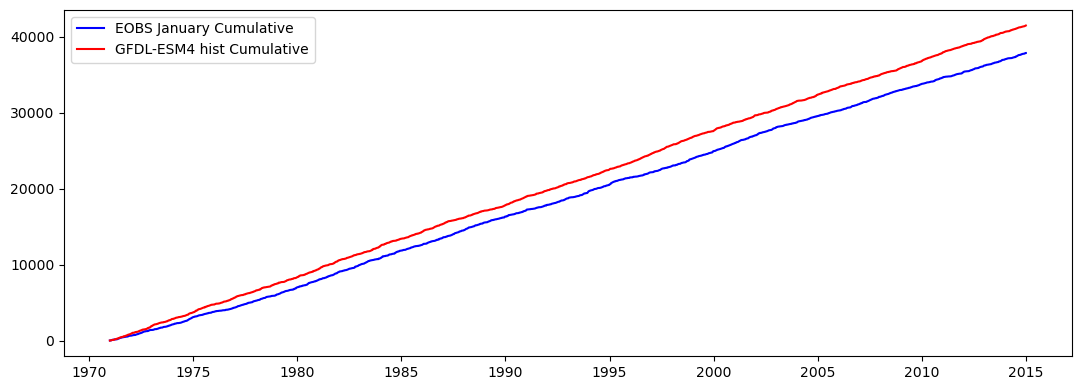

In [18]:
maxlat, minlat, minlon, maxlon = 51.5, 47.5, 4.5, 6.5


obs_df = obs.sel(lat=slice(maxlat, minlat), lon=slice(minlon, maxlon)).mean(dim=['lat', 'lon']).to_dataframe().resample('D').sum()
sim_hist_df = sim_hist.sel(lat=slice(maxlat, minlat), lon=slice(minlon, maxlon)).mean(dim=['lat', 'lon']).to_dataframe(name='pr_hist').resample('D').sum()
#hist_bc_df = hist_bc.sel(lat=slice(maxlat, minlat), lon=slice(minlon, maxlon)).mean(dim=['lat', 'lon']).to_dataframe(name='pr_hist_bc').resample('D').sum()
#fut_bc_df = fut_bc.sel(lat=slice(maxlat, minlat), lon=slice(minlon, maxlon)).mean(dim=['lat', 'lon']).to_dataframe(name='pr_fut_bc').resample('D').sum()

plt.figure(figsize=(13, 4.5))

plt.plot(np.cumsum(obs_df), c='b', label='EOBS January Cumulative')
#plt.plot(np.cumsum(hist_bc_df), c='g', label='GFDL-ESM4 historical EQM Cumulative')
plt.plot(np.cumsum(sim_hist_df), c='r', label='GFDL-ESM4 hist Cumulative')


plt.legend(loc='upper left', ncol=1)

print(f"Mean January EOBS: {np.mean(obs_jan):.2f} mm")
print(f"Mean January GFDL-ESM4 historical EQM: {np.mean(hist_jan_bc):.2f} mm")
print(f"Mean January GFDL-ESM4 historical: {np.mean(sim_hist_jan):.2f} mm")

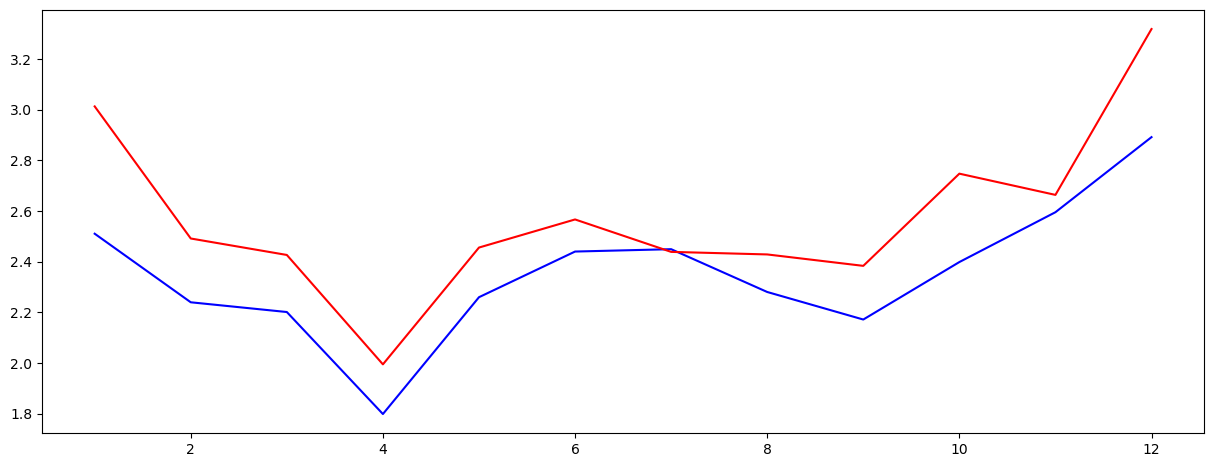

In [109]:
plt.figure(figsize=(15, 5.5))

plt.plot(obs_df.groupby(obs_df.index.month).mean(), label='EOBS monthly', c='b')
#plt.plot(hist_bc_df.groupby(hist_bc_df.index.month).mean(), label='hist EQM monthly', c='g')
plt.plot(sim_hist_df.groupby(sim_hist_df.index.month).mean(), label='Hist Monthly', c='r')
#plt.legend(loc='upper left', ncol=1)

#### QDM bias correction

In [110]:
import numpy as np
import pandas as pd
from typing import Tuple, Dict

# =============================================================================
# Quantile Delta Mapping (QDM) – DataFrame‑only, additive and multiplicative
# Now also supplies a helper to bias‑correct the **historical** simulation.
# =============================================================================

def compute_qdm_cdfs(
    obs_df: pd.DataFrame,
    simh_df: pd.DataFrame,
    n_quantiles: int = 250,
) -> Tuple[pd.DatetimeIndex, np.ndarray, Dict[str, np.ndarray], Dict[str, np.ndarray]]:
    """Compute empirical quantiles for observations and historical simulation.

    Returns
    -------
    common_index : DatetimeIndex – overlapping historical period
    ps           : ndarray        – probability grid (size = n_quantiles)
    q_obs        : dict[col → ndarray] – quantiles of obs   at ps
    q_simh       : dict[col → ndarray] – quantiles of sim_h at ps
    """
    # Align
    common_index = obs_df.index.intersection(simh_df.index)
    obs_aligned  = obs_df.reindex(common_index)
    simh_aligned = simh_df.reindex(common_index)

    ps = np.linspace(0.0, 1.0, n_quantiles)
    _q = lambda s: np.nanquantile(s.values, ps)

    q_obs  = {c: _q(obs_aligned[c])  for c in obs_aligned.columns}
    q_simh = {c: _q(simh_aligned[c]) for c in simh_aligned.columns}
    return common_index, ps, q_obs, q_simh

# -----------------------------------------------------------------------------
# QDM for the **future** simulation
# -----------------------------------------------------------------------------

def apply_qdm(
    simf_df: pd.DataFrame,
    ps: np.ndarray,
    q_obs: Dict[str, np.ndarray],
    q_simh: Dict[str, np.ndarray],
    kind: str = "+",
) -> pd.DataFrame:
    """Bias‑correct *future* simulation via QDM.

    Only columns present in both ``q_obs`` and ``q_simh`` are processed.
    Others are returned as NaN.
    """
    if kind not in {"+", "*"}:
        raise ValueError("kind must be '+' or '*'.")

    corrected = pd.DataFrame(index=simf_df.index, columns=simf_df.columns, dtype=float)

    for col in simf_df.columns:
        if col not in q_obs or col not in q_simh:
            continue

        obs_q, simh_q = q_obs[col], q_simh[col]
        fut_vals      = simf_df[col].values
        try:
            simf_q = np.nanquantile(fut_vals, ps)
        except ValueError:
            continue  # all‑NaN column

        # Delta per probability level
        if kind == "+":
            corr_q = obs_q + (simf_q - simh_q)
        else:
            with np.errstate(divide="ignore", invalid="ignore"):
                ratio  = np.where(simh_q != 0, simf_q / simh_q, np.nan)
            corr_q = obs_q * ratio

        # Map each future value
        p_vals          = np.interp(fut_vals, simf_q, ps, left=0.0, right=1.0)
        corrected_vals  = np.interp(p_vals, ps, corr_q)
        corrected[col]  = corrected_vals

    return corrected

# -----------------------------------------------------------------------------
# QDM for the **historical** simulation (equivalent to QM)
# -----------------------------------------------------------------------------

def apply_qdm_hist(
    simh_df: pd.DataFrame,
    ps: np.ndarray,
    q_obs: Dict[str, np.ndarray],
    q_simh: Dict[str, np.ndarray],
) -> pd.DataFrame:
    """Bias‑correct historical simulation using QDM (Δ = 0 ⇒ standard QM)."""

    corrected = pd.DataFrame(index=simh_df.index, columns=simh_df.columns, dtype=float)
    for col in simh_df.columns:
        if col not in q_obs or col not in q_simh:
            continue
        obs_q, simh_q = q_obs[col], q_simh[col]
        hist_vals     = simh_df[col].values
        p_vals        = np.interp(hist_vals, simh_q, ps, left=0.0, right=1.0)
        corrected[col] = np.interp(p_vals, ps, obs_q)
    return corrected

# -----------------------------------------------------------------------------
# Example usage
# -----------------------------------------------------------------------------
# common_idx, ps, q_obs, q_simh = compute_qdm_cdfs(obs_df, sim_hist_df)
# fut_corr = apply_qdm(sim_future_df, ps, q_obs, q_simh, kind='+')
# hist_corr = apply_qdm_hist(sim_hist_df, ps, q_obs, q_simh)


In [111]:
obs_df.columns=['pr']
sim_hist_df.columns=['pr']
sim_future_df.columns=['pr']

In [112]:
# 1. Build quantiles on overlapping historical period
common_idx, ps, q_obs, q_simh = compute_qdm_cdfs(obs_df, sim_hist_df)

# 2. Correct future
fut_corr_add = apply_qdm(sim_future_df, ps, q_obs, q_simh, kind='+')  
fut_corr_mul = apply_qdm(sim_future_df, ps, q_obs, q_simh, kind='*')   

# 3. Correct historical (for diagnostics / training)
hist_corr = apply_qdm_hist(sim_hist_df, ps, q_obs, q_simh)


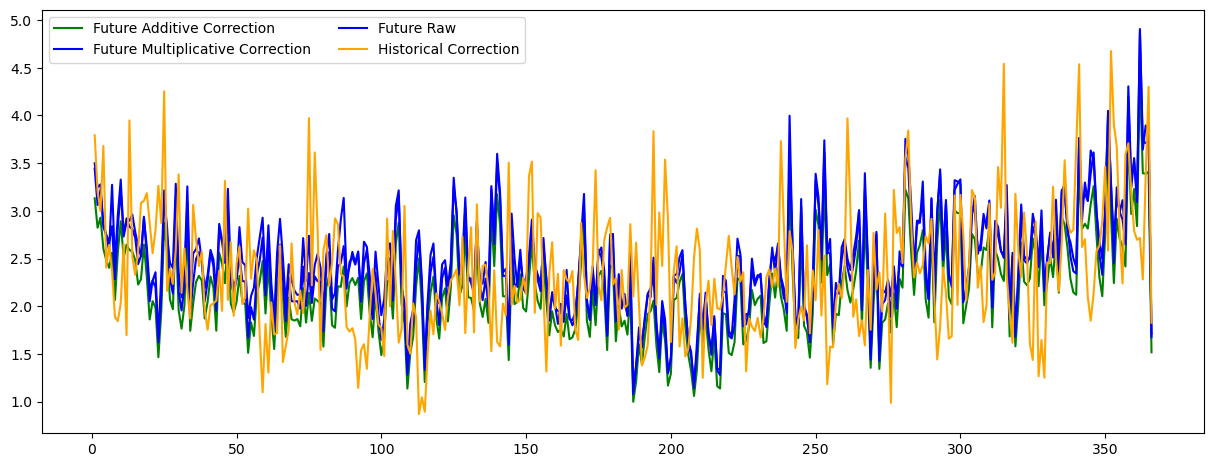

In [114]:
plt.figure(figsize=(15, 5.5))

plt.plot(fut_corr_add.groupby(fut_corr_add.index.dayofyear).mean(), label='Future Additive Correction', c='g')
plt.plot(fut_corr_mul.groupby(fut_corr_mul.index.dayofyear).mean(), label='Future Multiplicative Correction', c='b')
plt.plot(sim_future_df.groupby(sim_future_df.index.dayofyear).mean(), label='Future Raw', c='b')
plt.plot(hist_corr.groupby(hist_corr.index.dayofyear).mean(), label='Historical Correction', c='orange')


plt.legend(loc='upper left', ncol=2)

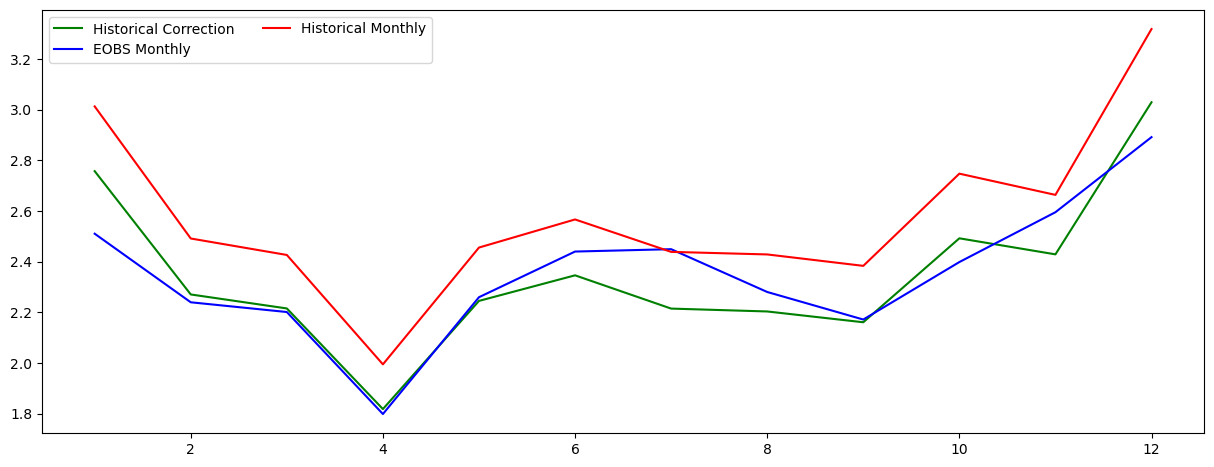

In [115]:
plt.figure(figsize=(15, 5.5))

plt.plot(hist_corr.groupby(hist_corr.index.month).mean()[0:180], label='Historical Correction', c='g')
plt.plot(obs_df.groupby(obs_df.index.month).mean()[0:180], label='EOBS Monthly', c='b')
plt.plot(sim_hist_df.groupby(sim_hist_df.index.month).mean()[0:180], label='Historical Monthly', c='r')

plt.legend(loc='upper left', ncol=2)

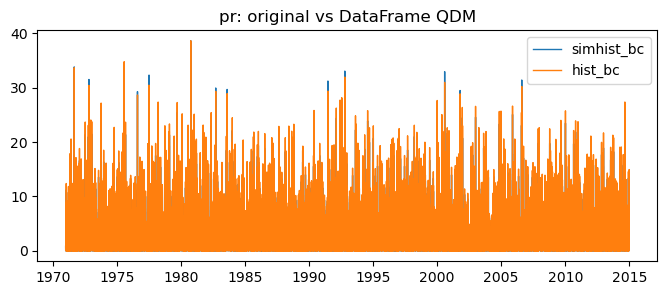

In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cmethods
from cmethods import adjust
from cmethods.distribution import quantile_delta_mapping   # original 1-D function

# ------- pick one column to demo (replace 'pr' with yours) -------------------
col = 'pr'                                       # or loop over sim_future_df.columns

# 1. slice 1-D series
obs_ser   = obs_df[col].dropna()
simh_ser  = sim_hist_df[col].reindex(obs_ser.index)  # align hist period
simp_ser  = sim_future_df[col]

# 2. original cmethods (additive)
fut_bc, simhist_bc = quantile_delta_mapping(
    obs=obs_ser.values,
    simh=simh_ser.values,
    simp=simp_ser.values,     # future
    n_quantiles=250,
    kind="*",
    adjust_called=True        # whatever your wrapper supplies
)


# 3. DataFrame QDM
idx, ps, qObs, qSimH = compute_qdm_cdfs(obs_ser.to_frame(), simh_ser.to_frame())
df_out  = apply_qdm(simp_ser.to_frame(), ps, qObs, qSimH, kind='+')
new_out = df_out[col].values



# 5. quick plot
plt.figure(figsize=(8,3))
plt.plot(simh_ser.index, simhist_bc, label='simhist_bc', lw=1)
#plt.plot(simh_ser.index, obs_ser , label='obs', lw=0.8, ls='--')
plt.plot(simh_ser.index, simh_ser, label='hist_bc', lw=1)
plt.legend(); plt.title(f"{col}: original vs DataFrame QDM"); plt.show()


Mean January EOBS: 2.35 mm
Mean January GFDL-ESM4 historical QDM: 2.37 mm
Mean January GFDL-ESM4 historical: 2.58 mm


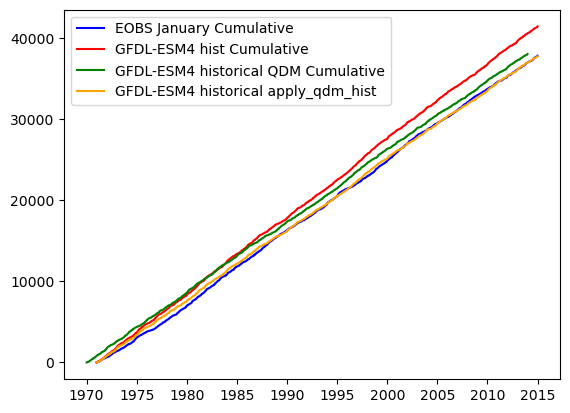

In [ ]:
plt.plot(np.cumsum(obs_ser), c='b', label='EOBS January Cumulative')
plt.plot(np.cumsum(simh_ser), c='r', label='GFDL-ESM4 hist Cumulative')
plt.plot(np.cumsum(simhist_bc), c='g', label='GFDL-ESM4 historical QDM Cumulative')
plt.plot(np.cumsum(hist_corr), c='orange', label='GFDL-ESM4 historical apply_qdm_hist')
plt.plot
plt.legend(loc='upper left', ncol=1)

print(f"Mean January EOBS: {np.mean(obs_ser):.2f} mm")
print(f"Mean January GFDL-ESM4 historical QDM: {np.mean(simhist_bc):.2f} mm")
print(f"Mean January GFDL-ESM4 historical: {np.mean(simh_ser):.2f} mm")

In [ ]:
import Parallel
from joblib import Parallel, delayed
from tqdm import tqdm
from itertools import product


nlat, nlon = len(obs.lat), len(obs.lon)
ntime_hist = len(obs.time)
ntime_fut = len(sim_future.time)
#nvalid = len(time)

# Preallocate array for only valid SPI values
spi_array = np.full((nlat, nlon, nvalid), np.nan)

def bias_correct_cell(j, i):
    obs_df = obs.isel(lat=j, lon=i)
    simh_df = sim_hist.isel(lat=j, lon=i)
    simp_df = sim_future.isel(lat=j, lon=i)

    if np.isnan(obs_df).all() or np.std(obs_df) < 1e-6:
        return (j, i, np.full(len(obs_df), np.nan))
    if np.isnan(simh_df).all() or np.std(simh_df) < 1e-6:
        return (j, i, np.full(len(obs_df), np.nan))
    
    common_idx, ps, q_obs, q_simh = compute_qdm_cdfs(obs_df, sim_hist_df)

    # 2. Correct future
    fut_corr_add = apply_qdm(sim_future_df, ps, q_obs, q_simh, kind='+')  
    fut_corr_mul = apply_qdm(sim_future_df, ps, q_obs, q_simh, kind='*')   

    # 3. Correct historical (for diagnostics / training)
    hist_corr = apply_qdm_hist(sim_hist_df, ps, q_obs, q_simh)

    return (j, i, hist_corr)

results = Parallel(n_jobs=-1)(
    delayed(bias_correct_cell)(j, i)
    for j, i in tqdm(product(range(nlat), range(nlon)), total=nlat*nlon, desc="Grid cells")
)


for j, i, spi_vals in results:
    spi_array[j, i, :] = spi_vals

spi_da = xr.DataArray(
    spi_array,
    coords={
        'lat': pre_cumulative.lat.values,
        'lon': pre_cumulative.lon.values,
        'time': valid_time.values,
    },
    dims=['lat', 'lon', 'time'],
    name='spi'
)

In [96]:
import numpy as np
import pandas as pd
import xarray as xr
from joblib import Parallel, delayed
from itertools import product
from tqdm.auto import tqdm

# ── 0. Dimensions & pre-allocate 3-D containers ────────────────────
nlat, nlon  = len(obs.lat), len(obs.lon)
ntime_hist  = len(obs.time)
ntime_fut   = len(sim_future.time)

hist_arr = np.full((nlat, nlon, ntime_hist), np.nan, dtype=float)
fut_arr  = np.full((nlat, nlon, ntime_fut ), np.nan, dtype=float)

# ── 1. Helper: bias-correct ONE grid-cell (j,i) ─────────────────────
def bias_correct_cell(j, i, n_quantiles=250, min_valid=10, kind="+"):
    """
    Returns (j, i, hist_bc, fut_bc)  — each bias-corrected 1-D NumPy array.
    If the cell is empty / has too few obs, returns None so caller can skip.
    """
    # extract cell as pandas Series
    obs_ser   = obs       .isel(lat=j, lon=i).to_series()
    simh_ser  = sim_hist  .isel(lat=j, lon=i).to_series()
    simp_ser  = sim_future.isel(lat=j, lon=i).to_series()

    # skip cells with no meaningful data
    if obs_ser.notna().sum() < min_valid or simh_ser.notna().sum() < min_valid:
        return None

    # make single-column DataFrames for helpers
    obs_df   = obs_ser .to_frame(name="cell")
    simh_df  = simh_ser.to_frame(name="cell")
    simp_df  = simp_ser.to_frame(name="cell")

    # 1. build quantiles on overlapping hist period
    _, ps, q_obs, q_simh = compute_qdm_cdfs(
        obs_df, simh_df, n_quantiles=n_quantiles
    )

    # 2. bias-correct future & historical
    fut_corr  = apply_qdm     (simp_df,  ps, q_obs, q_simh, kind=kind)["cell"].values
    hist_corr = apply_qdm_hist(simh_df,  ps, q_obs, q_simh)["cell"].values

    return j, i, hist_corr, fut_corr

# ── 2. Parallel loop over all grid-cells ───────────────────────────
results = Parallel(n_jobs=-1, verbose=0)(
    delayed(bias_correct_cell)(j, i, kind="+")   # or kind="*"
    for j, i in tqdm(product(range(nlat), range(nlon)),
                     total=nlat * nlon,
                     desc="QDM grid")
)

# ── 3. Paste results into the big NumPy arrays ─────────────────────
for item in results:
    if item is None:
        continue
    j, i, hist_vals, fut_vals = item
    hist_arr[j, i, :] = hist_vals
    fut_arr [j, i, :] = fut_vals

# ── 4. Convert back to xarray DataArrays ───────────────────────────
hist_bc_da = xr.DataArray(
    hist_arr,
    coords={"lat": obs.lat, "lon": obs.lon, "time": obs.time},
    dims=["lat", "lon", "time"],
    name="hist_qdm"
)

fut_bc_da = xr.DataArray(
    fut_arr,
    coords={"lat": obs.lat, "lon": obs.lon, "time": sim_future.time},
    dims=["lat", "lon", "time"],
    name="future_qdm"
)


QDM grid:   0%|          | 0/4480 [00:00<?, ?it/s]

hist_qdm_df: 2.36 mm
obs_df: 2.35 mm
hist_corr: 2.35 mm
sim_hist_df: 2.58 mm


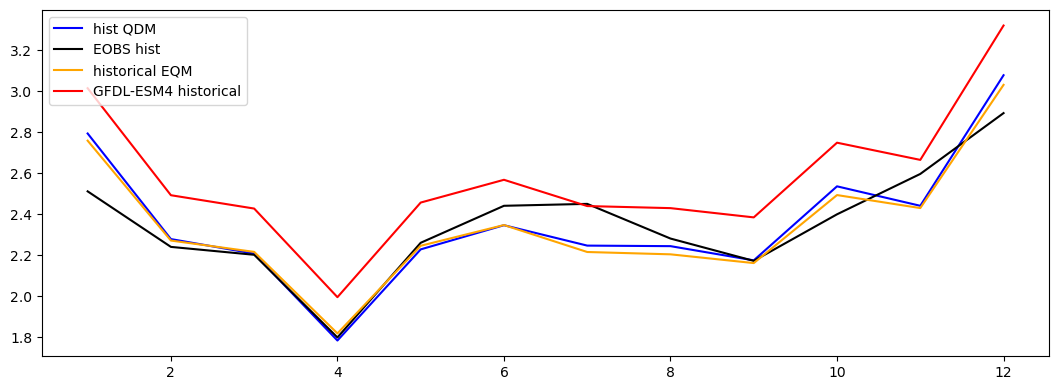

In [125]:
maxlat, minlat, minlon, maxlon = 51.5, 47.5, 4.5, 6.5


hist_qdm_df = hist_bc_da.sel(lat=slice(maxlat, minlat), lon=slice(minlon, maxlon)).mean(dim=['lat', 'lon']).to_dataframe().resample('D').sum()
obs_df = obs.sel(lat=slice(maxlat, minlat), lon=slice(minlon, maxlon)).mean(dim=['lat', 'lon']).to_dataframe().resample('D').sum()


fig, ax = plt.subplots(figsize=(13, 4.5))
plt.plot(hist_qdm_df.groupby(hist_qdm_df.index.month).mean(), label='hist QDM', c='b')
plt.plot(obs_df.groupby(obs_df.index.month).mean(), label='EOBS hist', c='k')
plt.plot(hist_corr.groupby(hist_corr.index.month).mean(), label='historical EQM', c='orange')

plt.plot(sim_hist_df.groupby(sim_hist_df.index.month).mean(), label='GFDL-ESM4 historical', c='r')

plt.legend(loc='upper left', ncol=1)

#----
print(f"hist_qdm_df: {hist_qdm_df.mean().values[0]:.2f} mm")
print(f"obs_df: {obs_df.mean().values[0]:.2f} mm")
print(f"hist_corr: {hist_corr.mean().values[0]:.2f} mm")
print(f"sim_hist_df: {sim_hist_df.mean().values[0]:.2f} mm")

